## Libs and Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import os
import seaborn as sn
from torchsummary import summary

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.data import random_split

from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from typing import Type

In [3]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Read Data and create Train, test and validation sets

In [4]:
# Define transformations for normalization only (for validation and test)
transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
# Download CIFAR-10 dataset and apply transformations
train_SVHN = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_SVHN = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
test_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
# Print the number of samples in the train and test sets
print(f"Number of SVHN training samples: {len(train_SVHN)}")
print(f"Number of SVHN testing samples: {len(test_SVHN)}")
print(f"Number of MNIST testing samples: {len(test_mnist)}")

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Number of SVHN training samples: 73257
Number of SVHN testing samples: 26032
Number of MNIST testing samples: 10000


In [6]:
# Create data loaders for train and test sets
train_dataloader = torch.utils.data.DataLoader(dataset=train_SVHN, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_SVHN, batch_size=16, shuffle=False)
mnist_dataloader = torch.utils.data.DataLoader(dataset=test_mnist, batch_size=16, shuffle=True)

In [7]:
def convert_to_3ch(images):
    # images shape: (batch_size, 1, 28, 28)
    # Convert to (batch_size, 3, 28, 28)
    return torch.cat([images, images, images], dim=1)

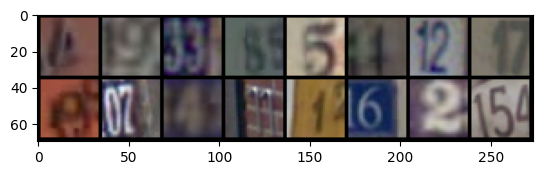

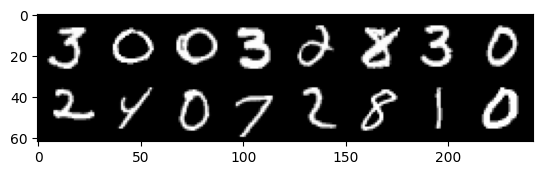

In [8]:
# Checking a sample batch and dataloader
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out)
inputs, classes = next(iter(mnist_dataloader))
inputs = convert_to_3ch(inputs)
out = torchvision.utils.make_grid(inputs)
imshow(out)

## Train

### Train function which include training the model and calculation of acc and loss in each epoch

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, train_dataloader, test_dataloader, mnist_dataloader):
    since = time.time()
    # model.load_state_dict(torch.load('model_weights.pth'))
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    test_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    test_acc = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 15)
        tic = time.time()
        # Each epoch has a training and validation phase
        ### Training
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        trainset_size = 0
        for batch_idx, data in enumerate(train_dataloader):
            inputs = data[0].to(device)
            labels = data[1].to(device)
            trainset_size += len(labels)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        scheduler.step()
        epoch_loss = running_loss / len(train_SVHN)
        epoch_acc = running_corrects.double() / len(train_SVHN)
        train_loss[epoch] = epoch_loss
        train_acc[epoch] = epoch_acc
        print(f'Training: Loss = {epoch_loss:.4f} Acc =  {epoch_acc:.4f}')
        ### Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for batch_idx, data in enumerate(test_dataloader):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(test_SVHN)
            epoch_acc = running_corrects.double() / len(test_SVHN)

            val_loss[epoch] = epoch_loss
            val_acc[epoch] = epoch_acc
        print(f'SVHN Test: Loss = {epoch_loss:.4f} Acc =  {epoch_acc:.4f}')

        ## MNIST
        running_loss = 0.0
        running_corrects = 0
        for batch_idx, data in enumerate(mnist_dataloader):
            inputs = data[0].to(device)
            inputs = convert_to_3ch(inputs)
            labels = data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(test_mnist)
            epoch_acc = running_corrects.double() / len(test_mnist)

            test_loss[epoch] = epoch_loss
            test_acc[epoch] = epoch_acc
            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = copy.deepcopy(epoch_acc)
                best_model_wts = copy.deepcopy(model.state_dict())
        print(f'MNIST: Loss = {epoch_loss:.4f} Acc =  {epoch_acc:.4f}')
        toc = time.time()
        print(f'Time: {(toc-tic) // 60:.0f}m {(toc-tic) % 60:.0f}s')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss,train_acc,val_loss,val_acc, test_loss, test_acc

## Resnet18

In [23]:
class Model_resnet18(nn.Module):
    def __init__(self, num_classes=10):
        super(Model_resnet18, self).__init__()
        self.model = models.resnet18(weights='IMAGENET1K_V1')
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, num_classes)
        )
    def forward(self, x):
        output = self.model(x)
        return output

In [24]:
model = Model_resnet18(num_classes=10).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Main

In [29]:
# Create an instance of the model
model_1 = Model_resnet18(num_classes=10).to(device)
# Define learning parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.0008, momentum=0.9, weight_decay=2e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

model_ft,train_loss,train_acc,val_loss,val_acc, test_loss, test_acc = train_model(model_1, criterion,
                                optimizer, exp_lr_scheduler, num_epochs=10, train_dataloader=train_dataloader, test_dataloader=test_dataloader, mnist_dataloader=mnist_dataloader)

Epoch 0/9
---------------
Training: Loss = 0.6840 Acc =  0.7846
SVHN Test: Loss = 0.3746 Acc =  0.8924
MNIST: Loss = 1.4920 Acc =  0.5429
Time: 1m 18s

Epoch 1/9
---------------
Training: Loss = 0.3511 Acc =  0.8957
SVHN Test: Loss = 0.2789 Acc =  0.9200
MNIST: Loss = 1.4072 Acc =  0.5288
Time: 1m 11s

Epoch 2/9
---------------
Training: Loss = 0.2769 Acc =  0.9194
SVHN Test: Loss = 0.2678 Acc =  0.9256
MNIST: Loss = 1.3948 Acc =  0.5353
Time: 1m 11s

Epoch 3/9
---------------
Training: Loss = 0.2362 Acc =  0.9312
SVHN Test: Loss = 0.2472 Acc =  0.9304
MNIST: Loss = 1.4455 Acc =  0.5275
Time: 1m 11s

Epoch 4/9
---------------
Training: Loss = 0.2039 Acc =  0.9404
SVHN Test: Loss = 0.2724 Acc =  0.9171
MNIST: Loss = 1.7039 Acc =  0.5170
Time: 1m 13s

Epoch 5/9
---------------
Training: Loss = 0.1782 Acc =  0.9483
SVHN Test: Loss = 0.2456 Acc =  0.9302
MNIST: Loss = 1.4456 Acc =  0.5746
Time: 1m 11s

Epoch 6/9
---------------
Training: Loss = 0.1593 Acc =  0.9524
SVHN Test: Loss = 0.2355

### Plot acc and loss for each epoch

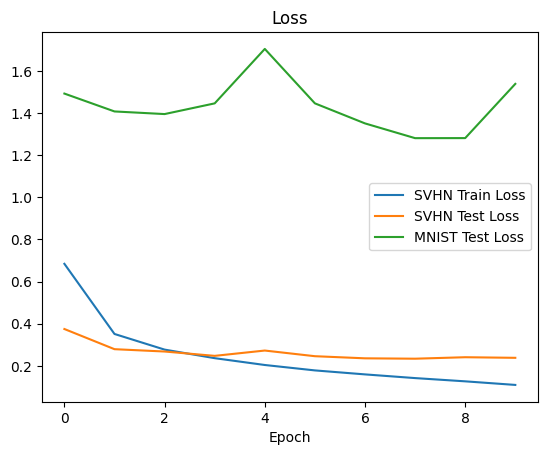

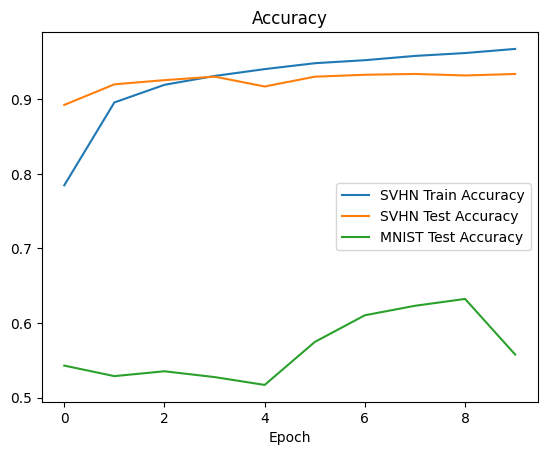

In [30]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(test_loss)
plt.legend(['SVHN Train Loss','SVHN Test Loss', 'MNIST Test Loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()
plt.plot(train_acc)
plt.plot(val_acc)
plt.plot(test_acc)
plt.legend(['SVHN Train Accuracy','SVHN Test Accuracy', 'MNIST Test Accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Test

### Load test data and give it to the trained model

In [31]:
labels = torch.tensor([])
preds = torch.tensor([])
model_ft.eval()
for batch_idx, data in enumerate(mnist_dataloader):
    # for inputs, labels in test_dataloader:
    inputs = data[0].to(device)
    inputs = convert_to_3ch(inputs)
    labels_temp = data[1].to(device)
    with torch.no_grad():
        outputs = model_ft(inputs)
        _, preds_temp = torch.max(outputs, 1)
    labels = torch.cat([labels, labels_temp.cpu()], dim=0)
    preds = torch.cat([preds, preds_temp.cpu()], dim=0)
    torch.cuda.empty_cache()

### Test accuracy and confusion matrix

Accuracy: 0.63
confusion matrix=
 [[567   3 244   4  47   0   2  11   2 100]
 [  0 665  28   3 263   0   4 159   6   7]
 [  8   7 868  32  13   1   0  82   0  21]
 [  0   0  23 851   0   9   0  37   3  87]
 [  0 122  38  19 529   4   3 179   8  80]
 [  3   8  11  52   2 640  42   6  23 105]
 [ 37   1  15   4 532   9 310   1  35  14]
 [  0  28 163   6   2   0   0 817   1  11]
 [  3   1  79 204   9  15  51  88 445  79]
 [  1  10  91   3  29   5   1 219  19 631]]


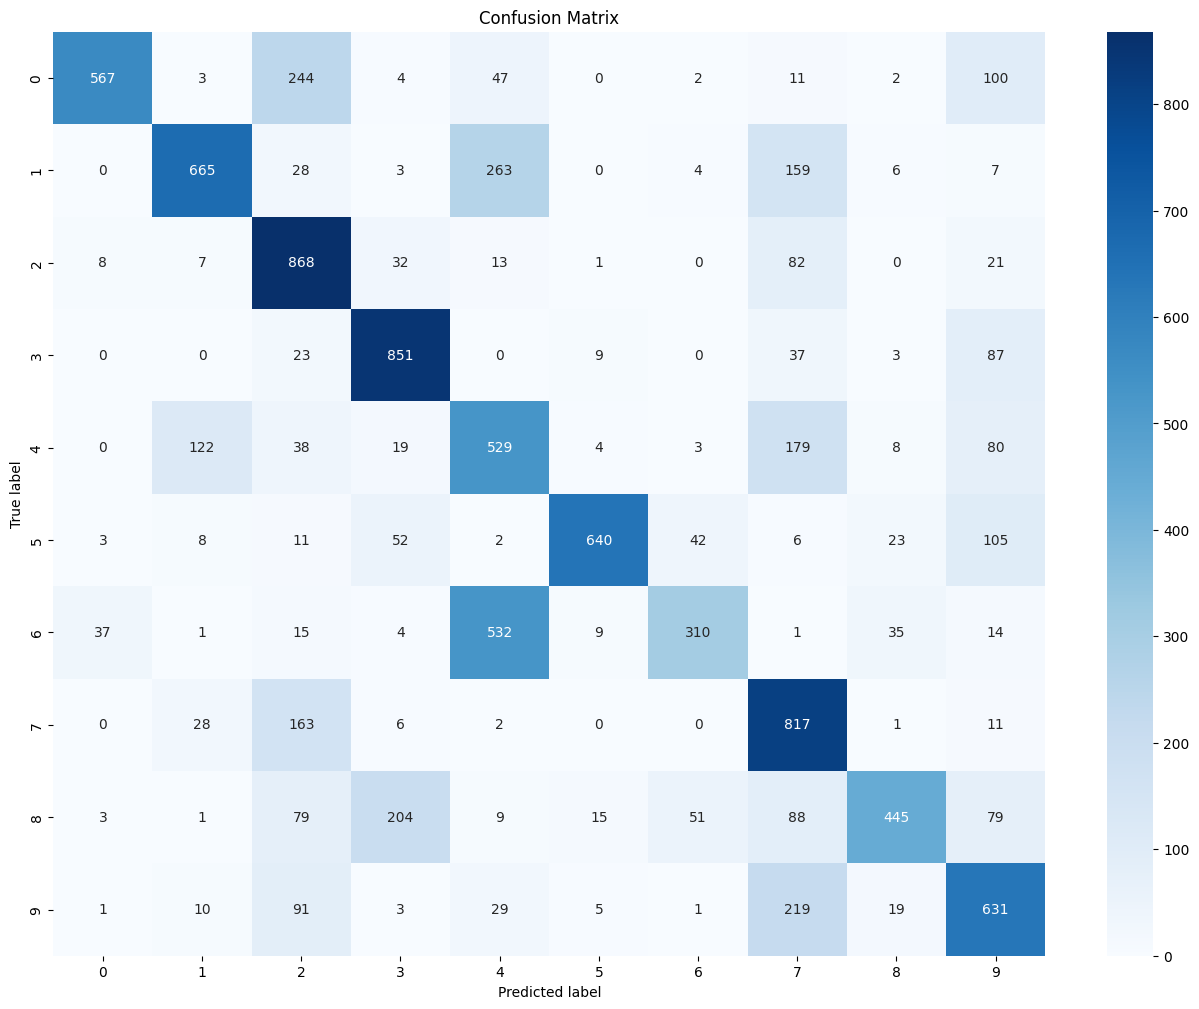

In [32]:
import sklearn
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

print(f"Accuracy: {accuracy:.2f}")
from sklearn.metrics import confusion_matrix , classification_report
class_names = ['0','1','2','3','4','5','6','7','8','9']
confusion_mtx = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
print("confusion matrix=\n",confusion_mtx)
plt.figure(figsize=(16,12))
sn.heatmap(confusion_mtx, annot=True,cmap="Blues", fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()